Problem statement: To build a CNN based model which can accurately detect melanoma. Melanoma is a type of cancer that can be deadly if not detected early. It accounts for 75% of skin cancer deaths. A solution which can evaluate images and alert the dermatologists about the presence of melanoma has the potential to reduce a lot of manual effort needed in diagnosis.

### Importing all the important libraries


In [1]:
import pathlib
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
import PIL
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from glob import glob

In [2]:
## If you are using the data by mounting the google drive, use the following :
from google.colab import drive
drive.mount('/content/gdrive')
!unzip "/content/gdrive/MyDrive/CNN_assignment.zip" > /dev/null

Mounted at /content/gdrive


In [3]:
# Defining the path for train and test images
## Todo: Update the paths of the train and test dataset
data_dir_train = pathlib.Path("/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/")
data_dir_test = pathlib.Path("/content/Skin cancer ISIC The International Skin Imaging Collaboration/Test/")

In [4]:
image_count_train = len(list(data_dir_train.glob('*/*.jpg')))
print(image_count_train)
image_count_test = len(list(data_dir_test.glob('*/*.jpg')))
print(image_count_test)

2239
118


### Load using keras.preprocessing

Let's load these images off disk using the helpful image_dataset_from_directory utility.

Create a dataset
Define some parameters for the loader:

In [5]:
batch_size = 32
img_height = 180
img_width = 180

Use 80% of the images for training, and 20% for validation.

In [6]:
## train dataset
## seed=123 used while creating dataset using tf.keras.preprocessing.image_dataset_from_directory
## resized images to the size img_height*img_width, while writting the dataset

train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)


Found 2239 files belonging to 9 classes.
Using 1792 files for training.


In [7]:
## validation dataset
## seed=123 used while creating dataset using tf.keras.preprocessing.image_dataset_from_directory
## resized images to the size img_height*img_width, while writting the dataset
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 2239 files belonging to 9 classes.
Using 447 files for validation.


In [8]:
# Listed out all the classes of skin cancer and stored them in a list. 
# You can find the class names in the class_names attribute on these datasets. 
# These correspond to the directory names in alphabetical order.
class_names = train_ds.class_names
print(class_names)

['actinic keratosis', 'basal cell carcinoma', 'dermatofibroma', 'melanoma', 'nevus', 'pigmented benign keratosis', 'seborrheic keratosis', 'squamous cell carcinoma', 'vascular lesion']


Visualize the data
Created a code to visualize one instance of all the nine classes present in the dataset

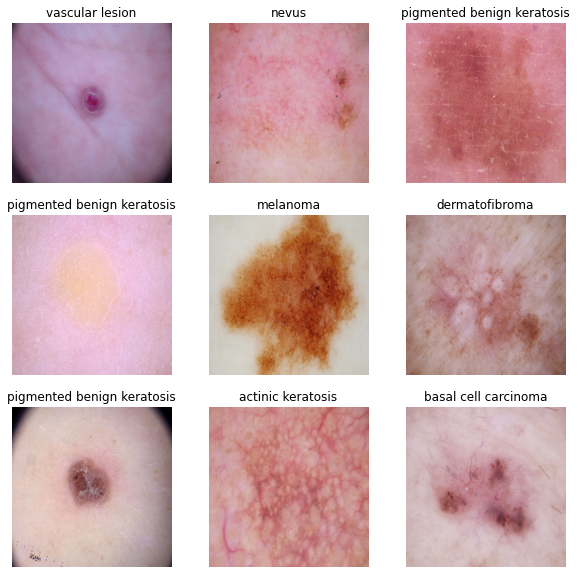

In [9]:
import matplotlib.pyplot as plt

### your code goes here, you can use training or validation data to visualize

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

The `image_batch` is a tensor of the shape `(32, 180, 180, 3)`. This is a batch of 32 images of shape `180x180x3` (the last dimension refers to color channels RGB). The `label_batch` is a tensor of the shape `(32,)`, these are corresponding labels to the 32 images.

Dataset.cache() keeps the images in memory after they're loaded off disk during the first epoch.

Dataset.prefetch() overlaps data preprocessing and model execution while training.

In [10]:
AUTOTUNE = tf.data.experimental.AUTOTUNE
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [11]:
from keras.layers.convolutional import Conv2D
from tensorflow.keras.layers import BatchNormalization
from keras.layers import Dense, Activation, Flatten, Dropout

### Create the model
#### Todo: Create a CNN model, which can accurately detect 9 classes present in the dataset. Use ```layers.experimental.preprocessing.Rescaling``` to normalize pixel values between (0,1). The RGB channel values are in the `[0, 255]` range. This is not ideal for a neural network. Here, it is good to standardize values to be in the `[0, 1]`

In [12]:
### Your code goes here
activ = 'relu'

from keras.layers import Dense, Dropout, Activation,Flatten, Conv2D, MaxPool2D
num_classes = 9
model = Sequential([
    layers.experimental.preprocessing.Rescaling(1./255, input_shape=(img_height, img_width,3))                   
])
model.add(Conv2D(filters=32, kernel_size=(3,3),activation='relu',input_shape=(180,180,3)))
model.add(MaxPool2D(pool_size=(2,2)))

model.add(Conv2D(filters=64, kernel_size=(3,3),activation='relu'))
model.add(MaxPool2D(pool_size=(2,2)))

model.add(Conv2D(filters=128, kernel_size=(3,3),padding='Same',activation='relu'))
model.add(MaxPool2D(pool_size=(2,2)))

model.add(Flatten())
model.add(Dense(512,activation='relu'))
model.add(Dense(1))
model.add(Activation('sigmoid'))

Compile the model
Choose an appropirate optimiser and loss function for model training

In [13]:
from tensorflow.keras.optimizers import Adam

### Appropirate optimiser and loss function chosen
model.compile(optimizer="Adam",
              loss="categorical_crossentropy",
              metrics=['accuracy'])


In [14]:
# View the summary of all layers
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling (Rescaling)       (None, 180, 180, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 178, 178, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 89, 89, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 87, 87, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 43, 43, 64)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 43, 43, 128)       7

In [15]:
epochs = 20
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
  )


Epoch 1/20
56/56 [==============================] - 24s 89ms/step - loss: 0.0000e+00 - accuracy: 0.1724 - val_loss: 0.0000e+00 - val_accuracy: 0.1499
Epoch 2/20
56/56 [==============================] - 2s 43ms/step - loss: 0.0000e+00 - accuracy: 0.1724 - val_loss: 0.0000e+00 - val_accuracy: 0.1499
Epoch 3/20
56/56 [==============================] - 2s 44ms/step - loss: 0.0000e+00 - accuracy: 0.1724 - val_loss: 0.0000e+00 - val_accuracy: 0.1499
Epoch 4/20
56/56 [==============================] - 2s 44ms/step - loss: 0.0000e+00 - accuracy: 0.1724 - val_loss: 0.0000e+00 - val_accuracy: 0.1499
Epoch 5/20
56/56 [==============================] - 2s 44ms/step - loss: 0.0000e+00 - accuracy: 0.1724 - val_loss: 0.0000e+00 - val_accuracy: 0.1499
Epoch 6/20
56/56 [==============================] - 2s 44ms/step - loss: 0.0000e+00 - accuracy: 0.1724 - val_loss: 0.0000e+00 - val_accuracy: 0.1499
Epoch 7/20
56/56 [==============================] - 2s 44ms/step - loss: 0.0000e+00 - accuracy: 0.1724 - 

Visualizing training results

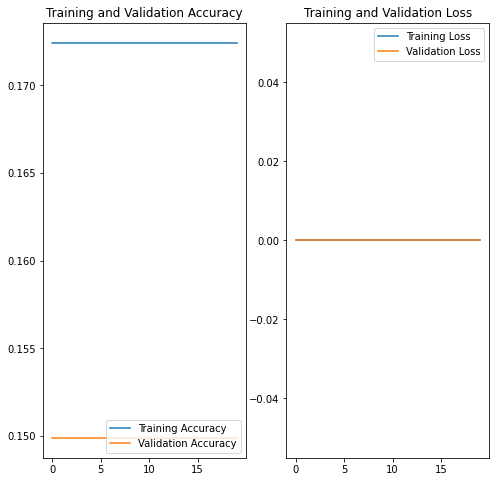

In [16]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

#### Todo: Write your findings after the model fit, see if there is an evidence of model overfit or underfit

Overfitting is seen in the above graph. 

When accuracy of train dataset is increases the validation dataset accuracy decreases.
If loss of train dataset is decreases the validation dataset accuracy is increasing drastically.

In [17]:
# Data augumentation strategy 
data_augument = keras.Sequential([
    layers.experimental.preprocessing.RandomFlip(mode="horizontal_and_vertical",input_shape=(img_height,img_width,3)),
    layers.experimental.preprocessing.RandomRotation(0.2, fill_mode='reflect'),
    layers.experimental.preprocessing.RandomZoom(height_factor=(0.2,0.3), width_factor=(0.2,0.3),fill_mode='reflect')
])

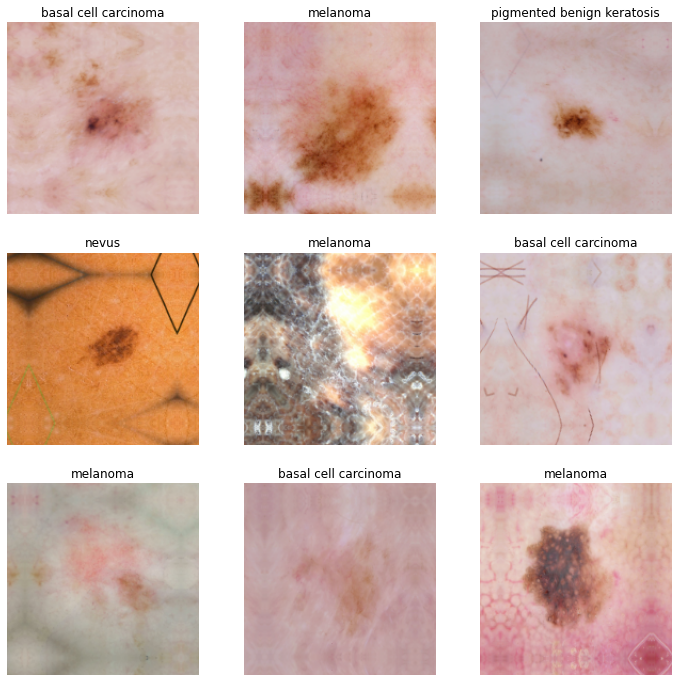

In [18]:
# Todo, visualize how your augmentation strategy works for one instance of training image.
plt.figure(figsize=(12,12))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax=plt.subplot(3,3,i+1)
    plt.imshow(data_augument(images)[i].numpy().astype('uint8'))
    plt.title(class_names[labels[i]])
    plt.axis("off")

Todo:
Create the model, compile and train the model¶

In [19]:
## Used Dropout layer in model building due to evidence of overfitting


from keras.layers import Dense, Dropout, Flatten,Conv2D, MaxPool2D
num_classes = 9
model = Sequential([data_augument,
                    layers.experimental.preprocessing.Rescaling(1./255, input_shape=(img_height, img_width,3))])

model.add(Conv2D(filters=32, kernel_size=(3,3), padding='Same',activation='relu',input_shape=(180,180,3)))
model.add(Conv2D(filters=32, kernel_size=(3,3), padding='Same',activation='relu'))
model.add(MaxPool2D(pool_size=(2,2)))
model.add(Dropout(0.25))

model.add(Conv2D(filters=64, kernel_size=(3,3), padding='Same',activation='relu'))
model.add(Conv2D(filters=64, kernel_size=(3,3), padding='Same',activation='relu'))
model.add(MaxPool2D(pool_size=(2,2)))
model.add(Dropout(0.4))

model.add(Conv2D(filters=128, kernel_size=(3,3),activation='relu'))
model.add(MaxPool2D(pool_size=(2,2)))
model.add(Dropout(0.4))
model.add(Flatten())
model.add(Dense(num_classes, activation='softmax'))


### Compiling the model

In [20]:
## Your code goes here
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

### Training the model

In [21]:
## Your code goes here, note: train your model for 20 epochs
epochs=20
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)
    

Epoch 1/20


/usr/local/lib/python3.7/dist-packages/tensorflow/python/util/dispatch.py:1082: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  return dispatch_target(*args, **kwargs)


56/56 [==============================] - 8s 97ms/step - loss: 2.0696 - accuracy: 0.2059 - val_loss: 2.0862 - val_accuracy: 0.3423
Epoch 2/20
56/56 [==============================] - 5s 95ms/step - loss: 1.8276 - accuracy: 0.3276 - val_loss: 1.6102 - val_accuracy: 0.3937
Epoch 3/20
56/56 [==============================] - 5s 93ms/step - loss: 1.6646 - accuracy: 0.4102 - val_loss: 1.7390 - val_accuracy: 0.3669
Epoch 4/20
56/56 [==============================] - 5s 87ms/step - loss: 1.5394 - accuracy: 0.4559 - val_loss: 1.4993 - val_accuracy: 0.4855
Epoch 5/20
56/56 [==============================] - 5s 86ms/step - loss: 1.5020 - accuracy: 0.4699 - val_loss: 1.4780 - val_accuracy: 0.5145
Epoch 6/20
56/56 [==============================] - 5s 87ms/step - loss: 1.4726 - accuracy: 0.4838 - val_loss: 1.4722 - val_accuracy: 0.4944
Epoch 7/20
56/56 [==============================] - 5s 87ms/step - loss: 1.4749 - accuracy: 0.4877 - val_loss: 1.4614 - val_accuracy: 0.4855
Epoch 8/20
56/56 [======

### Visualizing the results

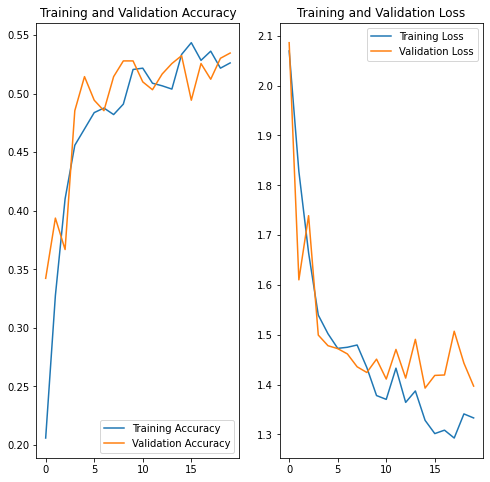

In [23]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

#### Todo: Write your findings after the model fit, see if there is an evidence of model overfit or underfit. Do you think there is some improvement now as compared to the previous model run?

Model accuracy has gone up considerably along with sync of validation accuracy. The loss function has been depleteing synchronously for the training & validation data.

#### **Todo:** Find the distribution of classes in the training dataset.
#### **Context:** Many times real life datasets can have class imbalance, one class can have proportionately higher number of samples compared to the others. Class imbalance can have a detrimental effect on the final model quality. Hence as a sanity check it becomes important to check what is the distribution of classes in the data.

In [24]:
## Your code goes here.
path_list=[]
lesion_list=[]
for i in class_names:
  for j in data_dir_train.glob(i+'/*.jpg'):
    path_list.append(str(j))
    lesion_list.append(i)
dataframe_dict_original = dict(zip(path_list, lesion_list))
original_df = pd.DataFrame(list(dataframe_dict_original.items()),columns=['Path','Label'])
original_df

,Path,Label
0,/content/Skin cancer ISIC The International Sk...,actinic keratosis
1,/content/Skin cancer ISIC The International Sk...,actinic keratosis
2,/content/Skin cancer ISIC The International Sk...,actinic keratosis
3,/content/Skin cancer ISIC The International Sk...,actinic keratosis
4,/content/Skin cancer ISIC The International Sk...,actinic keratosis
...,...,...
2234,/content/Skin cancer ISIC The International Sk...,vascular lesion
2235,/content/Skin cancer ISIC The International Sk...,vascular lesion
2236,/content/Skin cancer ISIC The International Sk...,vascular lesion
2237,/content/Skin cancer ISIC The International Sk...,vascular lesion


<BarContainer object of 9 artists>

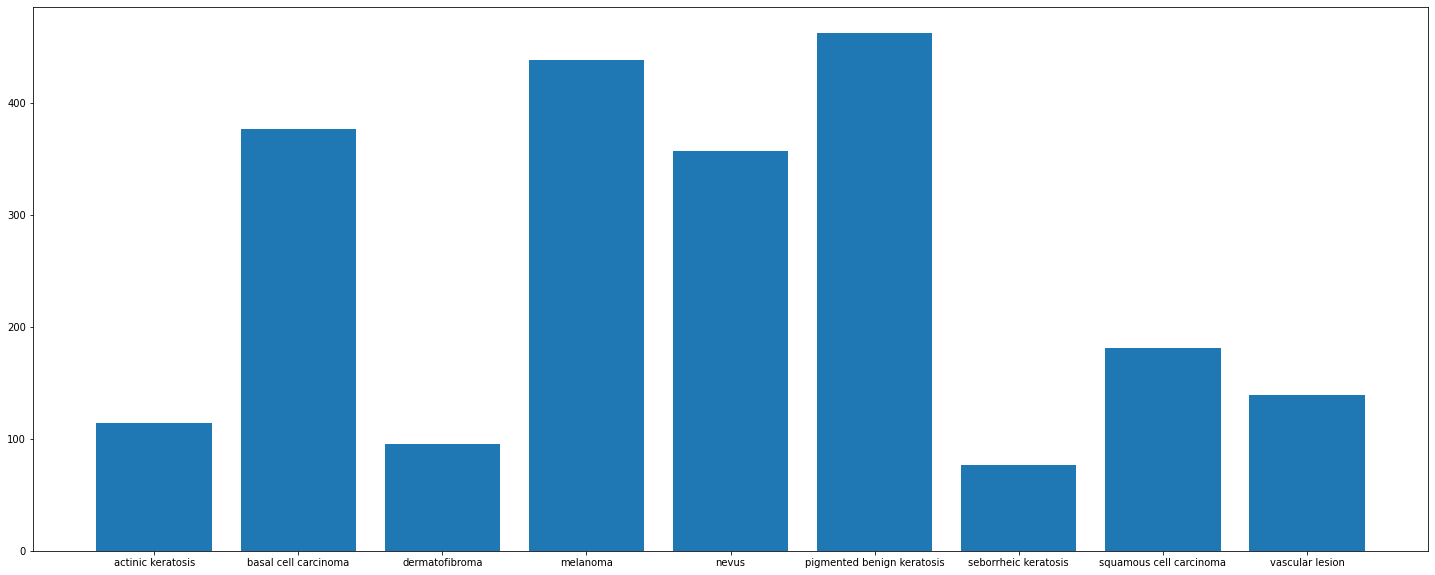

In [27]:
count=[]
for i in class_names:
  count.append(len(list(data_dir_train.glob(i+'/*.jpg'))))
plt.figure(figsize=(25,10))
plt.bar(class_names,count)

Todo: Write your findings here:
- Which class has the least number of samples? -- seborrheic keratosis
- Which classes dominate the data in terms proportionate number of samples? - melanoma and pigmented benign keratosis

Todo: Rectify the class imbalance
Context: You can use a python package known as Augmentor (https://augmentor.readthedocs.io/en/master/) to add more samples across all classes so that none of the classes have very few samples.

In [28]:
!pip install Augmentor

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


To use `Augmentor`, the following general procedure is followed:

1. Instantiate a `Pipeline` object pointing to a directory containing your initial image data set.<br>
2. Define a number of operations to perform on this data set using your `Pipeline` object.<br>
3. Execute these operations by calling the `Pipeline’s` `sample()` method.

In [29]:
path_to_training_dataset="/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/"
import Augmentor
for i in class_names:
    p = Augmentor.Pipeline(path_to_training_dataset + i)
    p.rotate(probability=0.7, max_left_rotation=10, max_right_rotation=10)
    p.sample(500) ## We are adding 500 samples per class to make sure that none of the classes are sparse.

Initialised with 114 image(s) found.
Output directory set to /content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/actinic keratosis/output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=600x450 at 0x7EFC7A754390>: 100%|██████████| 500/500 [00:17<00:00, 28.90 Samples/s]


Initialised with 376 image(s) found.
Output directory set to /content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/basal cell carcinoma/output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=600x450 at 0x7EFD12063ED0>: 100%|██████████| 500/500 [00:16<00:00, 29.80 Samples/s]


Initialised with 95 image(s) found.
Output directory set to /content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/dermatofibroma/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7EFC7A6E9850>: 100%|██████████| 500/500 [00:17<00:00, 29.03 Samples/s]


Initialised with 438 image(s) found.
Output directory set to /content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/melanoma/output.

Processing <PIL.Image.Image image mode=RGB size=1024x768 at 0x7EFD120DC7D0>: 100%|██████████| 500/500 [01:26<00:00,  5.76 Samples/s]


Initialised with 357 image(s) found.
Output directory set to /content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/nevus/output.

Processing <PIL.Image.Image image mode=RGB size=919x802 at 0x7EFD1216F9D0>: 100%|██████████| 500/500 [01:24<00:00,  5.93 Samples/s]


Initialised with 462 image(s) found.
Output directory set to /content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/pigmented benign keratosis/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7EFD12073150>: 100%|██████████| 500/500 [00:17<00:00, 29.00 Samples/s]


Initialised with 77 image(s) found.
Output directory set to /content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/seborrheic keratosis/output.

Processing <PIL.Image.Image image mode=RGB size=1024x768 at 0x7EFD12154F90>: 100%|██████████| 500/500 [00:44<00:00, 11.19 Samples/s]


Initialised with 181 image(s) found.
Output directory set to /content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/squamous cell carcinoma/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7EFCDC031790>: 100%|██████████| 500/500 [00:16<00:00, 30.90 Samples/s]


Initialised with 139 image(s) found.
Output directory set to /content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/vascular lesion/output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=600x450 at 0x7EFD12053C90>: 100%|██████████| 500/500 [00:15<00:00, 31.51 Samples/s]


Augmentor has stored the augmented images in the output sub-directory of each of the sub-directories of skin cancer types.. Lets take a look at total count of augmented images.

In [30]:
image_count_train = len(list(data_dir_train.glob('*/output/*.jpg')))
print(image_count_train)

4500


### Lets see the distribution of augmented data after adding new images to the original training data.


In [31]:
path_list = [x for x in glob(os.path.join(data_dir_train, '*','output', '*.jpg'))]
path_list

['/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/actinic keratosis/output/actinic keratosis_original_ISIC_0030242.jpg_5c529e59-12f2-4599-8ad0-abd92c03fde7.jpg',
 '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/actinic keratosis/output/actinic keratosis_original_ISIC_0033151.jpg_9e40e7c2-760a-4233-9b47-c5afca59e921.jpg',
 '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/actinic keratosis/output/actinic keratosis_original_ISIC_0026729.jpg_2253a47c-72d6-46f8-9738-8a4cef26a3aa.jpg',
 '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/actinic keratosis/output/actinic keratosis_original_ISIC_0030586.jpg_3dbeb1ab-b0ef-4c22-9f43-946004e81413.jpg',
 '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/actinic keratosis/output/actinic keratosis_original_ISIC_0028941.jpg_2c58f7f0-f98b-4566-86a1-d4ac07945931.jpg',
 '/content/Skin cancer ISIC The International

In [32]:
lesion_list_new = [os.path.basename(os.path.dirname(os.path.dirname(y))) for y in glob(os.path.join(data_dir_train, '*','output', '*.jpg'))]
lesion_list_new

['actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic 

In [33]:
dataframe_dict_new = dict(zip(path_list, lesion_list_new))



In [35]:
df2 = pd.DataFrame(list(dataframe_dict_new.items()),columns = ['Path','Label'])
new_df = original_df.append(df2)

In [36]:
new_df['Label'].value_counts()

pigmented benign keratosis    962
melanoma                      938
basal cell carcinoma          876
nevus                         857
squamous cell carcinoma       681
vascular lesion               639
actinic keratosis             614
dermatofibroma                595
seborrheic keratosis          577
Name: Label, dtype: int64

So, now we have added 500 images to all the classes to maintain some class balance. We can add more images as we want to improve training process.

Todo: Train the model on the data created using Augmentor

In [37]:
batch_size = 32
img_height = 180
img_width = 180

Todo: Create a training dataset

In [38]:
data_dir_train="/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/"
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  seed=123,
  validation_split = 0.2,
  subset = 'training',
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 6739 files belonging to 9 classes.
Using 5392 files for training.


#### **Todo:** Create a validation dataset

In [39]:
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  seed=123,
  validation_split = 0.2,
  subset = "validation",
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 6739 files belonging to 9 classes.
Using 1347 files for validation.


Todo: Create your model (make sure to include normalization)

In [40]:
## your code goes here

from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D
num_classes = 9
model = Sequential([ 
                    layers.experimental.preprocessing.Rescaling(1./255, input_shape=(img_height, img_width,3))
      
])
model.add(Conv2D(filters = 32, kernel_size = (3,3),padding = 'Same', 
                 activation ='relu', input_shape = (180, 180, 3)))
model.add(Conv2D(filters = 32, kernel_size = (3,3),padding = 'Same', 
                 activation ='relu'))
model.add(MaxPool2D(pool_size=(2,2)))
model.add(BatchNormalization())
model.add(Dropout(0.25))

model.add(Conv2D(filters = 64, kernel_size = (3,3),padding = 'Same', 
                 activation ='relu'))
model.add(MaxPool2D(pool_size=(2,2)))
model.add(Conv2D(filters = 64, kernel_size = (3,3),padding = 'Same', 
                 activation ='relu'))
model.add(MaxPool2D(pool_size=(2,2)))
model.add(BatchNormalization())
model.add(Dropout(0.4))

model.add(Conv2D(filters = 128, kernel_size = (3,3), 
                 activation ='relu'))
model.add(BatchNormalization())
model.add(MaxPool2D(pool_size=(2,2)))
model.add(Dropout(0.4))

model.add(Flatten())
model.add(Dense(num_classes, activation = "softmax"))

Todo: Compile your model (Choose optimizer and loss function appropriately)

In [41]:
## your code goes here
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

Todo: Train your model

In [42]:
epochs = 30
## Your code goes here, use 50 epochs.
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/30


/usr/local/lib/python3.7/dist-packages/tensorflow/python/util/dispatch.py:1082: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  return dispatch_target(*args, **kwargs)


169/169 [==============================] - 29s 159ms/step - loss: 3.1998 - accuracy: 0.3676 - val_loss: 3.5637 - val_accuracy: 0.1418
Epoch 2/30
169/169 [==============================] - 27s 153ms/step - loss: 2.4403 - accuracy: 0.4672 - val_loss: 3.9053 - val_accuracy: 0.1151
Epoch 3/30
169/169 [==============================] - 26s 147ms/step - loss: 2.0417 - accuracy: 0.5223 - val_loss: 2.8669 - val_accuracy: 0.3437
Epoch 4/30
169/169 [==============================] - 30s 170ms/step - loss: 1.9834 - accuracy: 0.5501 - val_loss: 21.8543 - val_accuracy: 0.1633
Epoch 5/30
169/169 [==============================] - 28s 161ms/step - loss: 1.7993 - accuracy: 0.5723 - val_loss: 4.5261 - val_accuracy: 0.3623
Epoch 6/30
169/169 [==============================] - 27s 157ms/step - loss: 1.6277 - accuracy: 0.5935 - val_loss: 2.2917 - val_accuracy: 0.4944
Epoch 7/30
169/169 [==============================] - 25s 144ms/step - loss: 1.3697 - accuracy: 0.6361 - val_loss: 1.8341 - val_accuracy: 0.

#### **Todo:**  Visualize the model results

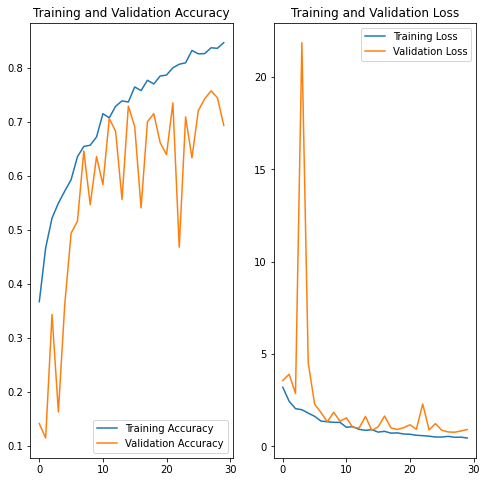

In [43]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

#### **Todo:**  Analyze your results here. Did you get rid of underfitting/overfitting? Did class rebalance help?



Yes, the problem of underfitting/overfitting has been solved. Class rebalance has helped in improving the performance of the model.